<a href="https://colab.research.google.com/github/nomchanz/graduation_thesis_new/blob/main/forwardNN_n500_rawdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 必要なライブラリのimport
import csv
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input, concatenate
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

In [2]:
# データの準備、読み込み


## データファイルのpath(位置データはrawの方)
no_hole_path = 'no_hole_data.csv'
one_hole_size_path = 'one_hole_size_data.csv'
one_hole_position_path = 'one_hole_position_data_raw.csv'
four_holes_size_path = 'four_holes_size_data.csv'
four_holes_position_path = 'four_holes_position_data_raw.csv'
nine_holes_size_path = 'nine_holes_size_data.csv'
nine_holes_position_path = 'nine_holes_position_data_raw.csv'
sixteen_holes_size_path = 'sixteen_holes_size_data.csv'
sixteen_holes_position_path = 'sixteen_holes_position_data_raw.csv'
twentyfive_holes_size_path = 'twentyfive_holes_size_data.csv'
twentyfive_holes_position_path = 'twentyfive_holes_position_data_raw.csv'


## csvファイルをリスト化

### 穴なしの温度分布データ
with open(no_hole_path) as f0:
  lst_f0 = list(csv.reader(f0))
lst_f0 = [r[:-1] for r in lst_f0]

### 大きさに関するデータ
with open(one_hole_size_path) as fs1:
  lst_fs1 = list(csv.reader(fs1))
with open(four_holes_size_path) as fs2:
  lst_fs2 = list(csv.reader(fs2))
with open(nine_holes_size_path) as fs3:
  lst_fs3 = list(csv.reader(fs3))
with open(sixteen_holes_size_path) as fs4:
  lst_fs4 = list(csv.reader(fs4))
with open(twentyfive_holes_size_path) as fs5:
  lst_fs5 = list(csv.reader(fs5))

### 位置に関するデータ
with open(one_hole_position_path) as fp1:
  lst_fp1 = list(csv.reader(fp1))
with open(four_holes_position_path) as fp2:
  lst_fp2 = list(csv.reader(fp2))
with open(nine_holes_position_path) as fp3:
  lst_fp3 = list(csv.reader(fp3))
with open(sixteen_holes_position_path) as fp4:
  lst_fp4 = list(csv.reader(fp4))
with open(twentyfive_holes_position_path) as fp5:
  lst_fp5 = list(csv.reader(fp5))

In [3]:
# model_1

# データの前処理


## 変数設定(各条件を変えてたくさん試すため)
n = 500                    #nは総抽出データ数
train = 0.8                 #train:validのtrainデータの割合
seed = 0                       
random.seed(seed)           #乱数seed固定


## データ加工

### データ抽出(各データをランダムにシャッフル→train,valid,testに分割。各大きさのデータが同じ数だけ抽出される。)
for i in range (1,6):
  exec("lst_fs"+str(i)+"_shuffle = random.sample(lst_fs"+str(i)+", len(lst_fs"+str(i)+"))")  
  exec("lst_fs"+str(i)+"_train = lst_fs"+str(i)+"_shuffle[0:"+str(int(n/5*train))+"]")       
  exec("lst_fs"+str(i)+"_valid = lst_fs"+str(i)+"_shuffle["+str(int(n/5*train))+":"+str(int(n/5))+"]")          
  exec("lst_fs"+str(i)+"_test = lst_fs"+str(i)+"_shuffle["+str(int(n/5))+":-1]")
  exec("lst_fp"+str(i)+"_shuffle = random.sample(lst_fp"+str(i)+", len(lst_fp"+str(i)+"))")
  exec("lst_fp"+str(i)+"_train = lst_fp"+str(i)+"_shuffle[0:"+str(int(n/5*train))+"]")
  exec("lst_fp"+str(i)+"_valid = lst_fp"+str(i)+"_shuffle["+str(int(n/5*train))+":"+str(int(n/5))+"]") 
  exec("lst_fp"+str(i)+"_test = lst_fp"+str(i)+"_shuffle["+str(int(n/5))+":-1]")

### train,valid,testの各々について、大きさ、位置、表面温度分布データに分割
for i in range (1,6):
  exec("lst_x_fs"+str(i)+"_train = [r[0] for r in lst_fs"+str(i)+"_train]")
  exec("lst_x_fp"+str(i)+"_train = [r[0:2] for r in lst_fp"+str(i)+"_train]")
  exec("lst_y"+str(i)+"_train = [r[2:-1] for r in lst_fp"+str(i)+"_train]")
  exec("lst_x_fs"+str(i)+"_valid = [r[0] for r in lst_fs"+str(i)+"_valid]")
  exec("lst_x_fp"+str(i)+"_valid = [r[0:2] for r in lst_fp"+str(i)+"_valid]")
  exec("lst_y"+str(i)+"_valid = [r[2:-1] for r in lst_fp"+str(i)+"_valid]")
  exec("lst_x_fs"+str(i)+"_test = [r[0] for r in lst_fs"+str(i)+"_test]")
  exec("lst_x_fp"+str(i)+"_test = [r[0:2] for r in lst_fp"+str(i)+"_test]")
  exec("lst_y"+str(i)+"_test = [r[2:-1] for r in lst_fp"+str(i)+"_test]")

### データを結合(入力データ・正解データの大枠完成)
lst_x_fs_train = lst_x_fs1_train + lst_x_fs2_train + lst_x_fs3_train + lst_x_fs4_train + lst_x_fs5_train
lst_x_fp_train = lst_x_fp1_train + lst_x_fp2_train + lst_x_fp3_train + lst_x_fp4_train + lst_x_fp5_train
lst_y_train = lst_y1_train + lst_y2_train + lst_y3_train + lst_y4_train + lst_y5_train

lst_x_fs_valid = lst_x_fs1_valid + lst_x_fs2_valid + lst_x_fs3_valid + lst_x_fs4_valid + lst_x_fs5_valid
lst_x_fp_valid = lst_x_fp1_valid + lst_x_fp2_valid + lst_x_fp3_valid + lst_x_fp4_valid + lst_x_fp5_valid
lst_y_valid = lst_y1_valid + lst_y2_valid + lst_y3_valid + lst_y4_valid + lst_y5_valid

lst_x_fs_test = lst_x_fs1_test + lst_x_fs2_test + lst_x_fs3_test + lst_x_fs4_test + lst_x_fs5_test
lst_x_fp_test = lst_x_fp1_test + lst_x_fp2_test + lst_x_fp3_test + lst_x_fp4_test + lst_x_fp5_test
lst_y_test = lst_y1_test + lst_y2_test + lst_y3_test + lst_y4_test + lst_y5_test

### np.arrayで変換
lst_f0 = np.array(lst_f0, dtype=float)
lst_x_fs_train = np.array(lst_x_fs_train, dtype=int)
lst_x_fp_train = np.array(lst_x_fp_train, dtype=int)
lst_x_fs_valid = np.array(lst_x_fs_valid, dtype=int)
lst_x_fp_valid = np.array(lst_x_fp_valid, dtype=int)
lst_x_fs_test = np.array(lst_x_fs_test, dtype=int)
lst_x_fp_test = np.array(lst_x_fp_test, dtype=int)
lst_y_train = np.array(lst_y_train, dtype=float)
lst_y_valid = np.array(lst_y_valid, dtype=float)
lst_y_test = np.array(lst_y_test, dtype=float)

### 大きさデータを二次元化
x_fs_train = lst_x_fs_train.reshape(-1, 1)
x_fs_valid = lst_x_fs_valid.reshape(-1, 1)
x_fs_test = lst_x_fs_test.reshape(-1, 1)


### 温度分布データを、穴なし温度分布データとの差に変換
y_train = lst_y_train - lst_f0
y_valid = lst_y_valid - lst_f0
y_test = lst_y_test - lst_f0

### 入力データの正規化
scaler_x = MinMaxScaler()
x_fs_train_n = scaler_x.fit_transform(x_fs_train)
x_fs_valid_n = scaler_x.fit_transform(x_fs_valid)
x_fs_test_n = scaler_x.fit_transform(x_fs_test) 
x_fp_train_n = scaler_x.fit_transform(lst_x_fp_train)
x_fp_valid_n = scaler_x.fit_transform(lst_x_fp_valid)
x_fp_test_n = scaler_x.fit_transform(lst_x_fp_test) 

In [4]:
lst_x_fp_train.shape

(400, 2)

In [5]:
# NN

## 入力を定義
input1 = Input(shape=(1,))
input2 = Input(shape=(2,))

## 入力1から結合前まで
x = Dense(1, activation="linear")(input1)
x = Model(inputs=input1, outputs=x)

## 入力2から結合前まで
y = Dense(2, activation="linear")(input2)
y = Model(inputs=input2, outputs=y)

## 結合
combined = concatenate([x.output, y.output])

## 密結合
z = Dense(32, activation="relu")(combined)
z = Dense(512, activation="relu")(z)
z = Dense(256, activation="relu")(z)
z = Dense(128, activation="relu")(z)
z = Dense(50)(z)

# モデル定義とコンパイル
model_1 = Model(inputs=[x.input, y.input], outputs=z)
model_1.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [6]:
# 学習
epochs = 2000
batch_size = 64
history_1 = model_1.fit([x_fs_train_n, x_fp_train_n], y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=([x_fs_valid_n, x_fp_valid_n], y_valid))

Epoch 1/2000
7/7 [==============================] - 1s 77ms/step - loss: 0.3091 - mae: 0.2615 - val_loss: 0.1561 - val_mae: 0.2031
Epoch 2/2000
7/7 [==============================] - 0s 11ms/step - loss: 0.2754 - mae: 0.2434 - val_loss: 0.1420 - val_mae: 0.1908
Epoch 3/2000
7/7 [==============================] - 0s 10ms/step - loss: 0.2616 - mae: 0.2220 - val_loss: 0.1334 - val_mae: 0.1812
Epoch 4/2000
7/7 [==============================] - 0s 10ms/step - loss: 0.1778 - mae: 0.1981 - val_loss: 0.1261 - val_mae: 0.1682
Epoch 5/2000
7/7 [==============================] - 0s 10ms/step - loss: 0.2831 - mae: 0.1903 - val_loss: 0.1215 - val_mae: 0.1697
Epoch 6/2000
7/7 [==============================] - 0s 11ms/step - loss: 0.1929 - mae: 0.1687 - val_loss: 0.1136 - val_mae: 0.1417
Epoch 7/2000
7/7 [==============================] - 0s 10ms/step - loss: 0.2057 - mae: 0.1532 - val_loss: 0.1049 - val_mae: 0.1346
Epoch 8/2000
7/7 [==============================] - 0s 10ms/step - loss: 0.1961 - m

In [7]:
# モデルの評価
score = model_1.evaluate([x_fs_test_n, x_fp_test_n], y_test, verbose=1)
print('Test loss:', score[0])
print('Test mae:', score[1])

301/301 [==============================] - 0s 1ms/step - loss: 0.0806 - mae: 0.0454
Test loss: 0.08061391860246658
Test mae: 0.04537998512387276


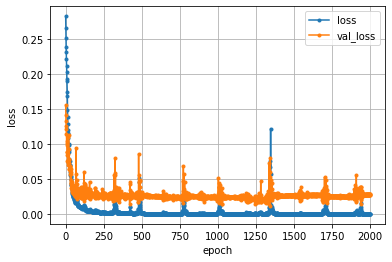

In [8]:
# 学習経過の可視化
loss     = history_1.history['loss']
val_loss = history_1.history['val_loss']

nb_epoch = len(loss)
for i in range(50):
  if max(loss)>0.3: 
    if i == 49:
      plt.plot(range(i,nb_epoch), loss, marker='.', label='loss')
      plt.plot(range(i,nb_epoch), val_loss, marker='.', label='val_loss')
      break
    else:
      loss = loss[1:]
      val_loss = val_loss[1:]
  else:
    plt.plot(range(i,nb_epoch), loss, marker='.', label='loss')
    plt.plot(range(i,nb_epoch), val_loss, marker='.', label='val_loss')
    break
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

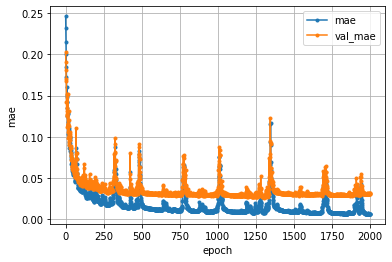

In [9]:
# 学習経過の可視化
mae     = history_1.history['mae']
val_mae = history_1.history['val_mae']

nb_epoch = len(mae)
for i in range(50):
  if max(mae)>0.3: 
    if i == 49:
      plt.plot(range(i,nb_epoch), mae, marker='.', label='mae')
      plt.plot(range(i,nb_epoch), val_mae, marker='.', label='val_mae')
      break
    else:
      mae = mae[1:]
      val_mae = val_mae[1:]
  else:
    plt.plot(range(i,nb_epoch), mae, marker='.', label='mae')
    plt.plot(range(i,nb_epoch), val_mae, marker='.', label='val_mae')
    break
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('mae')
plt.show()

In [10]:
# 学習モデルの保存
model_1.save(str(n)+"_random.seed("+str(seed)+")_train"+str(train)+"_raw.h5")

In [11]:
# model_2

# データの前処理


## 変数設定(各条件を変えてたくさん試すため)
train = 0.5                 #train:validのtrainデータの割合                      
random.seed(seed)           #乱数seed固定


## データ加工

### データ抽出(各データをランダムにシャッフル→train,valid,testに分割。各大きさのデータが同じ数だけ抽出される。)
for i in range (1,6):
  exec("lst_fs"+str(i)+"_shuffle = random.sample(lst_fs"+str(i)+", len(lst_fs"+str(i)+"))")  
  exec("lst_fs"+str(i)+"_train = lst_fs"+str(i)+"_shuffle[0:"+str(int(n/5*train))+"]")       
  exec("lst_fs"+str(i)+"_valid = lst_fs"+str(i)+"_shuffle["+str(int(n/5*train))+":"+str(int(n/5))+"]")          
  exec("lst_fs"+str(i)+"_test = lst_fs"+str(i)+"_shuffle["+str(int(n/5))+":-1]")
  exec("lst_fp"+str(i)+"_shuffle = random.sample(lst_fp"+str(i)+", len(lst_fp"+str(i)+"))")
  exec("lst_fp"+str(i)+"_train = lst_fp"+str(i)+"_shuffle[0:"+str(int(n/5*train))+"]")
  exec("lst_fp"+str(i)+"_valid = lst_fp"+str(i)+"_shuffle["+str(int(n/5*train))+":"+str(int(n/5))+"]") 
  exec("lst_fp"+str(i)+"_test = lst_fp"+str(i)+"_shuffle["+str(int(n/5))+":-1]")

### train,valid,testの各々について、大きさ、位置、表面温度分布データに分割
for i in range (1,6):
  exec("lst_x_fs"+str(i)+"_train = [r[0] for r in lst_fs"+str(i)+"_train]")
  exec("lst_x_fp"+str(i)+"_train = [r[0:2] for r in lst_fp"+str(i)+"_train]")
  exec("lst_y"+str(i)+"_train = [r[2:-1] for r in lst_fp"+str(i)+"_train]")
  exec("lst_x_fs"+str(i)+"_valid = [r[0] for r in lst_fs"+str(i)+"_valid]")
  exec("lst_x_fp"+str(i)+"_valid = [r[0:2] for r in lst_fp"+str(i)+"_valid]")
  exec("lst_y"+str(i)+"_valid = [r[2:-1] for r in lst_fp"+str(i)+"_valid]")
  exec("lst_x_fs"+str(i)+"_test = [r[0] for r in lst_fs"+str(i)+"_test]")
  exec("lst_x_fp"+str(i)+"_test = [r[0:2] for r in lst_fp"+str(i)+"_test]")
  exec("lst_y"+str(i)+"_test = [r[2:-1] for r in lst_fp"+str(i)+"_test]")

### データを結合(入力データ・正解データの大枠完成)
lst_x_fs_train = lst_x_fs1_train + lst_x_fs2_train + lst_x_fs3_train + lst_x_fs4_train + lst_x_fs5_train
lst_x_fp_train = lst_x_fp1_train + lst_x_fp2_train + lst_x_fp3_train + lst_x_fp4_train + lst_x_fp5_train
lst_y_train = lst_y1_train + lst_y2_train + lst_y3_train + lst_y4_train + lst_y5_train

lst_x_fs_valid = lst_x_fs1_valid + lst_x_fs2_valid + lst_x_fs3_valid + lst_x_fs4_valid + lst_x_fs5_valid
lst_x_fp_valid = lst_x_fp1_valid + lst_x_fp2_valid + lst_x_fp3_valid + lst_x_fp4_valid + lst_x_fp5_valid
lst_y_valid = lst_y1_valid + lst_y2_valid + lst_y3_valid + lst_y4_valid + lst_y5_valid

lst_x_fs_test = lst_x_fs1_test + lst_x_fs2_test + lst_x_fs3_test + lst_x_fs4_test + lst_x_fs5_test
lst_x_fp_test = lst_x_fp1_test + lst_x_fp2_test + lst_x_fp3_test + lst_x_fp4_test + lst_x_fp5_test
lst_y_test = lst_y1_test + lst_y2_test + lst_y3_test + lst_y4_test + lst_y5_test

### np.arrayで変換
lst_f0 = np.array(lst_f0, dtype=float)
lst_x_fs_train = np.array(lst_x_fs_train, dtype=int)
lst_x_fp_train = np.array(lst_x_fp_train, dtype=int)
lst_x_fs_valid = np.array(lst_x_fs_valid, dtype=int)
lst_x_fp_valid = np.array(lst_x_fp_valid, dtype=int)
lst_x_fs_test = np.array(lst_x_fs_test, dtype=int)
lst_x_fp_test = np.array(lst_x_fp_test, dtype=int)
lst_y_train = np.array(lst_y_train, dtype=float)
lst_y_valid = np.array(lst_y_valid, dtype=float)
lst_y_test = np.array(lst_y_test, dtype=float)

### 入力データを二次元化
x_fs_train = lst_x_fs_train.reshape(-1, 1)
x_fs_valid = lst_x_fs_valid.reshape(-1, 1)
x_fs_test = lst_x_fs_test.reshape(-1, 1)

### 温度分布データを、穴なし温度分布データとの差に変換
y_train = lst_y_train - lst_f0
y_valid = lst_y_valid - lst_f0
y_test = lst_y_test - lst_f0

### 入力データの正規化
scaler_x = MinMaxScaler()
x_fs_train_n = scaler_x.fit_transform(x_fs_train)
x_fs_valid_n = scaler_x.fit_transform(x_fs_valid)
x_fs_test_n = scaler_x.fit_transform(x_fs_test) 
x_fp_train_n = scaler_x.fit_transform(lst_x_fp_train)
x_fp_valid_n = scaler_x.fit_transform(lst_x_fp_valid)
x_fp_test_n = scaler_x.fit_transform(lst_x_fp_test) 

In [12]:
# NN

## 入力を定義
input1 = Input(shape=(1,))
input2 = Input(shape=(2,))

## 入力1から結合前まで
x = Dense(1, activation="linear")(input1)
x = Model(inputs=input1, outputs=x)

## 入力2から結合前まで
y = Dense(2, activation="linear")(input2)
y = Model(inputs=input2, outputs=y)

## 結合
combined = concatenate([x.output, y.output])

## 密結合
z = Dense(32, activation="relu")(combined)
z = Dense(512, activation="relu")(z)
z = Dense(256, activation="relu")(z)
z = Dense(128, activation="relu")(z)
z = Dense(50)(z)

## モデル定義とコンパイル
model_2 = Model(inputs=[x.input, y.input], outputs=z)
model_2.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [13]:
# 学習
epochs = 2000
batch_size = 64
history_2 = model_2.fit([x_fs_train_n, x_fp_train_n], y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=([x_fs_valid_n, x_fp_valid_n], y_valid))

Epoch 1/2000
4/4 [==============================] - 1s 65ms/step - loss: 0.3149 - mae: 0.2601 - val_loss: 0.1908 - val_mae: 0.2207
Epoch 2/2000
4/4 [==============================] - 0s 18ms/step - loss: 0.2966 - mae: 0.2321 - val_loss: 0.1802 - val_mae: 0.2114
Epoch 3/2000
4/4 [==============================] - 0s 17ms/step - loss: 0.3255 - mae: 0.2285 - val_loss: 0.1734 - val_mae: 0.2087
Epoch 4/2000
4/4 [==============================] - 0s 17ms/step - loss: 0.3190 - mae: 0.2227 - val_loss: 0.1676 - val_mae: 0.2003
Epoch 5/2000
4/4 [==============================] - 0s 18ms/step - loss: 0.2755 - mae: 0.2156 - val_loss: 0.1625 - val_mae: 0.1970
Epoch 6/2000
4/4 [==============================] - 0s 19ms/step - loss: 0.3176 - mae: 0.2234 - val_loss: 0.1583 - val_mae: 0.1960
Epoch 7/2000
4/4 [==============================] - 0s 19ms/step - loss: 0.2125 - mae: 0.2014 - val_loss: 0.1546 - val_mae: 0.1906
Epoch 8/2000
4/4 [==============================] - 0s 19ms/step - loss: 0.1871 - m

In [14]:
# モデルの評価
score = model_2.evaluate([x_fs_test_n, x_fp_test_n], y_test, verbose=1)
print('Test loss:', score[0])
print('Test mae:', score[1])

301/301 [==============================] - 0s 1ms/step - loss: 0.0903 - mae: 0.0566
Test loss: 0.09033993631601334
Test mae: 0.05662235990166664


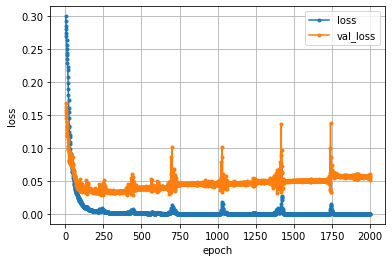

In [15]:
# 学習経過の可視化
loss     = history_2.history['loss']
val_loss = history_2.history['val_loss']

nb_epoch = len(loss)
for i in range(50):
  if max(loss)>0.3: 
    if i == 49:
      plt.plot(range(i,nb_epoch), loss, marker='.', label='loss')
      plt.plot(range(i,nb_epoch), val_loss, marker='.', label='val_loss')
      break
    else:
      loss = loss[1:]
      val_loss = val_loss[1:]
  else:
    plt.plot(range(i,nb_epoch), loss, marker='.', label='loss')
    plt.plot(range(i,nb_epoch), val_loss, marker='.', label='val_loss')
    break
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

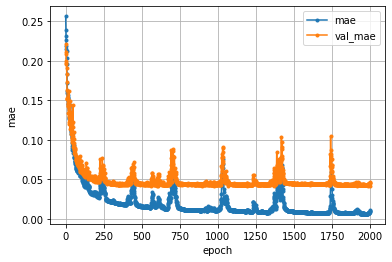

In [16]:
# 学習経過の可視化
mae     = history_2.history['mae']
val_mae = history_2.history['val_mae']

nb_epoch = len(mae)
for i in range(50):
  if max(mae)>0.3: 
    if i == 49:
      plt.plot(range(i,nb_epoch), mae, marker='.', label='mae')
      plt.plot(range(i,nb_epoch), val_mae, marker='.', label='val_mae')
      break
    else:
      mae = mae[1:]
      val_mae = val_mae[1:]
  else:
    plt.plot(range(i,nb_epoch), mae, marker='.', label='mae')
    plt.plot(range(i,nb_epoch), val_mae, marker='.', label='val_mae')
    break
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('mae')
plt.show()

In [17]:
# 学習モデルの保存
model_2.save(str(n)+"_random.seed("+str(seed)+")_train"+str(train)+"_raw.h5")

In [18]:
# model_3

# データの前処理


## 変数設定(各条件を変えてたくさん試すため)
train = 0.8                 #train:validのtrainデータの割合
seed = 1                       
random.seed(seed)           #乱数seed固定


## データ加工

### データ抽出(各データをランダムにシャッフル→train,valid,testに分割。各大きさのデータが同じ数だけ抽出される。)
for i in range (1,6):
  exec("lst_fs"+str(i)+"_shuffle = random.sample(lst_fs"+str(i)+", len(lst_fs"+str(i)+"))")  
  exec("lst_fs"+str(i)+"_train = lst_fs"+str(i)+"_shuffle[0:"+str(int(n/5*train))+"]")       
  exec("lst_fs"+str(i)+"_valid = lst_fs"+str(i)+"_shuffle["+str(int(n/5*train))+":"+str(int(n/5))+"]")          
  exec("lst_fs"+str(i)+"_test = lst_fs"+str(i)+"_shuffle["+str(int(n/5))+":-1]")
  exec("lst_fp"+str(i)+"_shuffle = random.sample(lst_fp"+str(i)+", len(lst_fp"+str(i)+"))")
  exec("lst_fp"+str(i)+"_train = lst_fp"+str(i)+"_shuffle[0:"+str(int(n/5*train))+"]")
  exec("lst_fp"+str(i)+"_valid = lst_fp"+str(i)+"_shuffle["+str(int(n/5*train))+":"+str(int(n/5))+"]") 
  exec("lst_fp"+str(i)+"_test = lst_fp"+str(i)+"_shuffle["+str(int(n/5))+":-1]")

### train,valid,testの各々について、大きさ、位置、表面温度分布データに分割
for i in range (1,6):
  exec("lst_x_fs"+str(i)+"_train = [r[0] for r in lst_fs"+str(i)+"_train]")
  exec("lst_x_fp"+str(i)+"_train = [r[0:2] for r in lst_fp"+str(i)+"_train]")
  exec("lst_y"+str(i)+"_train = [r[2:-1] for r in lst_fp"+str(i)+"_train]")
  exec("lst_x_fs"+str(i)+"_valid = [r[0] for r in lst_fs"+str(i)+"_valid]")
  exec("lst_x_fp"+str(i)+"_valid = [r[0:2] for r in lst_fp"+str(i)+"_valid]")
  exec("lst_y"+str(i)+"_valid = [r[2:-1] for r in lst_fp"+str(i)+"_valid]")
  exec("lst_x_fs"+str(i)+"_test = [r[0] for r in lst_fs"+str(i)+"_test]")
  exec("lst_x_fp"+str(i)+"_test = [r[0:2] for r in lst_fp"+str(i)+"_test]")
  exec("lst_y"+str(i)+"_test = [r[2:-1] for r in lst_fp"+str(i)+"_test]")

### データを結合(入力データ・正解データの大枠完成)
lst_x_fs_train = lst_x_fs1_train + lst_x_fs2_train + lst_x_fs3_train + lst_x_fs4_train + lst_x_fs5_train
lst_x_fp_train = lst_x_fp1_train + lst_x_fp2_train + lst_x_fp3_train + lst_x_fp4_train + lst_x_fp5_train
lst_y_train = lst_y1_train + lst_y2_train + lst_y3_train + lst_y4_train + lst_y5_train

lst_x_fs_valid = lst_x_fs1_valid + lst_x_fs2_valid + lst_x_fs3_valid + lst_x_fs4_valid + lst_x_fs5_valid
lst_x_fp_valid = lst_x_fp1_valid + lst_x_fp2_valid + lst_x_fp3_valid + lst_x_fp4_valid + lst_x_fp5_valid
lst_y_valid = lst_y1_valid + lst_y2_valid + lst_y3_valid + lst_y4_valid + lst_y5_valid

lst_x_fs_test = lst_x_fs1_test + lst_x_fs2_test + lst_x_fs3_test + lst_x_fs4_test + lst_x_fs5_test
lst_x_fp_test = lst_x_fp1_test + lst_x_fp2_test + lst_x_fp3_test + lst_x_fp4_test + lst_x_fp5_test
lst_y_test = lst_y1_test + lst_y2_test + lst_y3_test + lst_y4_test + lst_y5_test

### np.arrayで変換
lst_f0 = np.array(lst_f0, dtype=float)
lst_x_fs_train = np.array(lst_x_fs_train, dtype=int)
lst_x_fp_train = np.array(lst_x_fp_train, dtype=int)
lst_x_fs_valid = np.array(lst_x_fs_valid, dtype=int)
lst_x_fp_valid = np.array(lst_x_fp_valid, dtype=int)
lst_x_fs_test = np.array(lst_x_fs_test, dtype=int)
lst_x_fp_test = np.array(lst_x_fp_test, dtype=int)
lst_y_train = np.array(lst_y_train, dtype=float)
lst_y_valid = np.array(lst_y_valid, dtype=float)
lst_y_test = np.array(lst_y_test, dtype=float)

### 入力データを二次元化
x_fs_train = lst_x_fs_train.reshape(-1, 1)
x_fs_valid = lst_x_fs_valid.reshape(-1, 1)
x_fs_test = lst_x_fs_test.reshape(-1, 1)

### 温度分布データを、穴なし温度分布データとの差に変換
y_train = lst_y_train - lst_f0
y_valid = lst_y_valid - lst_f0
y_test = lst_y_test - lst_f0

### 入力データの正規化
scaler_x = MinMaxScaler()
x_fs_train_n = scaler_x.fit_transform(x_fs_train)
x_fs_valid_n = scaler_x.fit_transform(x_fs_valid)
x_fs_test_n = scaler_x.fit_transform(x_fs_test) 
x_fp_train_n = scaler_x.fit_transform(lst_x_fp_train)
x_fp_valid_n = scaler_x.fit_transform(lst_x_fp_valid)
x_fp_test_n = scaler_x.fit_transform(lst_x_fp_test) 

In [19]:
# NN

## 入力を定義
input1 = Input(shape=(1,))
input2 = Input(shape=(2,))

## 入力1から結合前まで
x = Dense(1, activation="linear")(input1)
x = Model(inputs=input1, outputs=x)

## 入力2から結合前まで
y = Dense(2, activation="linear")(input2)
y = Model(inputs=input2, outputs=y)

## 結合
combined = concatenate([x.output, y.output])

## 密結合
z = Dense(32, activation="relu")(combined)
z = Dense(512, activation="relu")(z)
z = Dense(256, activation="relu")(z)
z = Dense(128, activation="relu")(z)
z = Dense(50)(z)

## モデル定義とコンパイル
model_3 = Model(inputs=[x.input, y.input], outputs=z)
model_3.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [20]:
# 学習
epochs = 2000
batch_size = 64
history_3 = model_3.fit([x_fs_train_n, x_fp_train_n], y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=([x_fs_valid_n, x_fp_valid_n], y_valid))

Epoch 1/2000
7/7 [==============================] - 1s 32ms/step - loss: 0.5537 - mae: 0.2763 - val_loss: 0.2127 - val_mae: 0.2363
Epoch 2/2000
7/7 [==============================] - 0s 12ms/step - loss: 0.2901 - mae: 0.2132 - val_loss: 0.1908 - val_mae: 0.2145
Epoch 3/2000
7/7 [==============================] - 0s 10ms/step - loss: 0.4279 - mae: 0.2341 - val_loss: 0.1763 - val_mae: 0.1952
Epoch 4/2000
7/7 [==============================] - 0s 10ms/step - loss: 0.3166 - mae: 0.1887 - val_loss: 0.1640 - val_mae: 0.1748
Epoch 5/2000
7/7 [==============================] - 0s 11ms/step - loss: 0.2441 - mae: 0.1692 - val_loss: 0.1534 - val_mae: 0.1666
Epoch 6/2000
7/7 [==============================] - 0s 10ms/step - loss: 0.5011 - mae: 0.2084 - val_loss: 0.1469 - val_mae: 0.1683
Epoch 7/2000
7/7 [==============================] - 0s 10ms/step - loss: 0.4454 - mae: 0.1907 - val_loss: 0.1402 - val_mae: 0.1640
Epoch 8/2000
7/7 [==============================] - 0s 10ms/step - loss: 0.5467 - m

In [21]:
# モデルの評価
score = model_3.evaluate([x_fs_test_n, x_fp_test_n], y_test, verbose=1)
print('Test loss:', score[0])
print('Test mae:', score[1])

301/301 [==============================] - 0s 2ms/step - loss: 0.0538 - mae: 0.0408
Test loss: 0.053803011775016785
Test mae: 0.04077235236763954


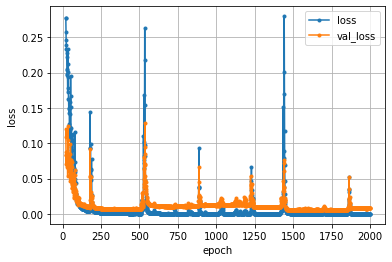

In [22]:
# 学習経過の可視化
loss     = history_3.history['loss']
val_loss = history_3.history['val_loss']

nb_epoch = len(loss)
for i in range(50):
  if max(loss)>0.3: 
    if i == 49:
      plt.plot(range(i,nb_epoch), loss, marker='.', label='loss')
      plt.plot(range(i,nb_epoch), val_loss, marker='.', label='val_loss')
      break
    else:
      loss = loss[1:]
      val_loss = val_loss[1:]
  else:
    plt.plot(range(i,nb_epoch), loss, marker='.', label='loss')
    plt.plot(range(i,nb_epoch), val_loss, marker='.', label='val_loss')
    break
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

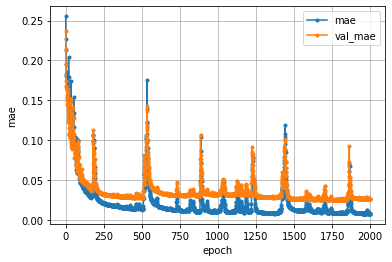

In [23]:
# 学習経過の可視化
mae     = history_3.history['mae']
val_mae = history_3.history['val_mae']

nb_epoch = len(mae)
for i in range(50):
  if max(mae)>0.3: 
    if i == 49:
      plt.plot(range(i,nb_epoch), mae, marker='.', label='mae')
      plt.plot(range(i,nb_epoch), val_mae, marker='.', label='val_mae')
      break
    else:
      mae = mae[1:]
      val_mae = val_mae[1:]
  else:
    plt.plot(range(i,nb_epoch), mae, marker='.', label='mae')
    plt.plot(range(i,nb_epoch), val_mae, marker='.', label='val_mae')
    break
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('mae')
plt.show()

In [24]:
# 学習モデルの保存
model_3.save(str(n)+"_random.seed("+str(seed)+")_train"+str(train)+"_raw.h5")

In [25]:
# model_4

# データの前処理


## 変数設定(各条件を変えてたくさん試すため)
train = 0.5                 #train:validのtrainデータの割合                       
random.seed(seed)           #乱数seed固定


## データ加工

### データ抽出(各データをランダムにシャッフル→train,valid,testに分割。各大きさのデータが同じ数だけ抽出される。)
for i in range (1,6):
  exec("lst_fs"+str(i)+"_shuffle = random.sample(lst_fs"+str(i)+", len(lst_fs"+str(i)+"))")  
  exec("lst_fs"+str(i)+"_train = lst_fs"+str(i)+"_shuffle[0:"+str(int(n/5*train))+"]")       
  exec("lst_fs"+str(i)+"_valid = lst_fs"+str(i)+"_shuffle["+str(int(n/5*train))+":"+str(int(n/5))+"]")          
  exec("lst_fs"+str(i)+"_test = lst_fs"+str(i)+"_shuffle["+str(int(n/5))+":-1]")
  exec("lst_fp"+str(i)+"_shuffle = random.sample(lst_fp"+str(i)+", len(lst_fp"+str(i)+"))")
  exec("lst_fp"+str(i)+"_train = lst_fp"+str(i)+"_shuffle[0:"+str(int(n/5*train))+"]")
  exec("lst_fp"+str(i)+"_valid = lst_fp"+str(i)+"_shuffle["+str(int(n/5*train))+":"+str(int(n/5))+"]") 
  exec("lst_fp"+str(i)+"_test = lst_fp"+str(i)+"_shuffle["+str(int(n/5))+":-1]")

### train,valid,testの各々について、大きさ、位置、表面温度分布データに分割
for i in range (1,6):
  exec("lst_x_fs"+str(i)+"_train = [r[0] for r in lst_fs"+str(i)+"_train]")
  exec("lst_x_fp"+str(i)+"_train = [r[0:2] for r in lst_fp"+str(i)+"_train]")
  exec("lst_y"+str(i)+"_train = [r[2:-1] for r in lst_fp"+str(i)+"_train]")
  exec("lst_x_fs"+str(i)+"_valid = [r[0] for r in lst_fs"+str(i)+"_valid]")
  exec("lst_x_fp"+str(i)+"_valid = [r[0:2] for r in lst_fp"+str(i)+"_valid]")
  exec("lst_y"+str(i)+"_valid = [r[2:-1] for r in lst_fp"+str(i)+"_valid]")
  exec("lst_x_fs"+str(i)+"_test = [r[0] for r in lst_fs"+str(i)+"_test]")
  exec("lst_x_fp"+str(i)+"_test = [r[0:2] for r in lst_fp"+str(i)+"_test]")
  exec("lst_y"+str(i)+"_test = [r[2:-1] for r in lst_fp"+str(i)+"_test]")

### データを結合(入力データ・正解データの大枠完成)
lst_x_fs_train = lst_x_fs1_train + lst_x_fs2_train + lst_x_fs3_train + lst_x_fs4_train + lst_x_fs5_train
lst_x_fp_train = lst_x_fp1_train + lst_x_fp2_train + lst_x_fp3_train + lst_x_fp4_train + lst_x_fp5_train
lst_y_train = lst_y1_train + lst_y2_train + lst_y3_train + lst_y4_train + lst_y5_train

lst_x_fs_valid = lst_x_fs1_valid + lst_x_fs2_valid + lst_x_fs3_valid + lst_x_fs4_valid + lst_x_fs5_valid
lst_x_fp_valid = lst_x_fp1_valid + lst_x_fp2_valid + lst_x_fp3_valid + lst_x_fp4_valid + lst_x_fp5_valid
lst_y_valid = lst_y1_valid + lst_y2_valid + lst_y3_valid + lst_y4_valid + lst_y5_valid

lst_x_fs_test = lst_x_fs1_test + lst_x_fs2_test + lst_x_fs3_test + lst_x_fs4_test + lst_x_fs5_test
lst_x_fp_test = lst_x_fp1_test + lst_x_fp2_test + lst_x_fp3_test + lst_x_fp4_test + lst_x_fp5_test
lst_y_test = lst_y1_test + lst_y2_test + lst_y3_test + lst_y4_test + lst_y5_test

### np.arrayで変換
lst_f0 = np.array(lst_f0, dtype=float)
lst_x_fs_train = np.array(lst_x_fs_train, dtype=int)
lst_x_fp_train = np.array(lst_x_fp_train, dtype=int)
lst_x_fs_valid = np.array(lst_x_fs_valid, dtype=int)
lst_x_fp_valid = np.array(lst_x_fp_valid, dtype=int)
lst_x_fs_test = np.array(lst_x_fs_test, dtype=int)
lst_x_fp_test = np.array(lst_x_fp_test, dtype=int)
lst_y_train = np.array(lst_y_train, dtype=float)
lst_y_valid = np.array(lst_y_valid, dtype=float)
lst_y_test = np.array(lst_y_test, dtype=float)

### 入力データを二次元化
x_fs_train = lst_x_fs_train.reshape(-1, 1)
x_fs_valid = lst_x_fs_valid.reshape(-1, 1)
x_fs_test = lst_x_fs_test.reshape(-1, 1)

### 温度分布データを、穴なし温度分布データとの差に変換
y_train = lst_y_train - lst_f0
y_valid = lst_y_valid - lst_f0
y_test = lst_y_test - lst_f0

### 入力データの正規化
scaler_x = MinMaxScaler()
x_fs_train_n = scaler_x.fit_transform(x_fs_train)
x_fs_valid_n = scaler_x.fit_transform(x_fs_valid)
x_fs_test_n = scaler_x.fit_transform(x_fs_test) 
x_fp_train_n = scaler_x.fit_transform(lst_x_fp_train)
x_fp_valid_n = scaler_x.fit_transform(lst_x_fp_valid)
x_fp_test_n = scaler_x.fit_transform(lst_x_fp_test) 

In [26]:
# NN

## 入力を定義
input1 = Input(shape=(1,))
input2 = Input(shape=(2,))

## 入力1から結合前まで
x = Dense(1, activation="linear")(input1)
x = Model(inputs=input1, outputs=x)

## 入力2から結合前まで
y = Dense(2, activation="linear")(input2)
y = Model(inputs=input2, outputs=y)

## 結合
combined = concatenate([x.output, y.output])

## 密結合
z = Dense(32, activation="relu")(combined)
z = Dense(512, activation="relu")(z)
z = Dense(256, activation="relu")(z)
z = Dense(128, activation="relu")(z)
z = Dense(50)(z)

## モデル定義とコンパイル
model_4 = Model(inputs=[x.input, y.input], outputs=z)
model_4.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [27]:
# 学習
epochs = 2000
batch_size = 64
history_4 = model_4.fit([x_fs_train_n, x_fp_train_n], y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=([x_fs_valid_n, x_fp_valid_n], y_valid))

Epoch 1/2000
4/4 [==============================] - 1s 67ms/step - loss: 0.1903 - mae: 0.2339 - val_loss: 0.5470 - val_mae: 0.2659
Epoch 2/2000
4/4 [==============================] - 0s 19ms/step - loss: 0.2749 - mae: 0.2319 - val_loss: 0.5412 - val_mae: 0.2514
Epoch 3/2000
4/4 [==============================] - 0s 19ms/step - loss: 0.2490 - mae: 0.2156 - val_loss: 0.5394 - val_mae: 0.2416
Epoch 4/2000
4/4 [==============================] - 0s 19ms/step - loss: 0.2549 - mae: 0.2046 - val_loss: 0.5349 - val_mae: 0.2279
Epoch 5/2000
4/4 [==============================] - 0s 18ms/step - loss: 0.2792 - mae: 0.1931 - val_loss: 0.5304 - val_mae: 0.2150
Epoch 6/2000
4/4 [==============================] - 0s 18ms/step - loss: 0.1858 - mae: 0.1665 - val_loss: 0.5264 - val_mae: 0.2080
Epoch 7/2000
4/4 [==============================] - 0s 18ms/step - loss: 0.1712 - mae: 0.1658 - val_loss: 0.5215 - val_mae: 0.2025
Epoch 8/2000
4/4 [==============================] - 0s 18ms/step - loss: 0.1411 - m

In [28]:
# モデルの評価
score = model_4.evaluate([x_fs_test_n, x_fp_test_n], y_test, verbose=1)
print('Test loss:', score[0])
print('Test mae:', score[1])

301/301 [==============================] - 0s 1ms/step - loss: 0.0912 - mae: 0.0551
Test loss: 0.09122198075056076
Test mae: 0.05509261414408684


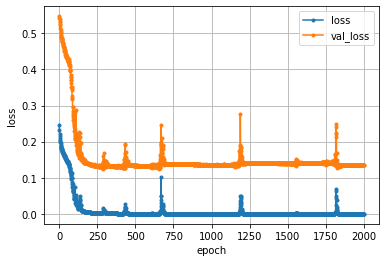

In [29]:
# 学習経過の可視化
loss     = history_4.history['loss']
val_loss = history_4.history['val_loss']

nb_epoch = len(loss)
for i in range(50):
  if max(loss)>0.3: 
    if i == 49:
      plt.plot(range(i,nb_epoch), loss, marker='.', label='loss')
      plt.plot(range(i,nb_epoch), val_loss, marker='.', label='val_loss')
      break
    else:
      loss = loss[1:]
      val_loss = val_loss[1:]
  else:
    plt.plot(range(i,nb_epoch), loss, marker='.', label='loss')
    plt.plot(range(i,nb_epoch), val_loss, marker='.', label='val_loss')
    break
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

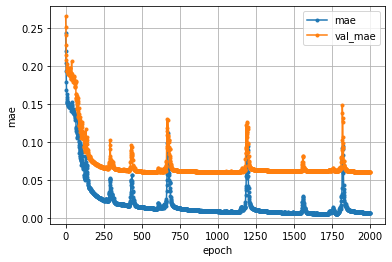

In [30]:
# 学習経過の可視化
mae     = history_4.history['mae']
val_mae = history_4.history['val_mae']

nb_epoch = len(mae)
for i in range(50):
  if max(mae)>0.3: 
    if i == 49:
      plt.plot(range(i,nb_epoch), mae, marker='.', label='mae')
      plt.plot(range(i,nb_epoch), val_mae, marker='.', label='val_mae')
      break
    else:
      mae = mae[1:]
      val_mae = val_mae[1:]
  else:
    plt.plot(range(i,nb_epoch), mae, marker='.', label='mae')
    plt.plot(range(i,nb_epoch), val_mae, marker='.', label='val_mae')
    break
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('mae')
plt.show()

In [31]:
# 学習モデルの保存
model_4.save(str(n)+"_random.seed("+str(seed)+")_train"+str(train)+"_raw.h5")